In [1]:
!pip install -q soundfile

In [2]:
#라이브러리
from google.colab import output
from base64 import b64decode
from IPython.display import Audio, display
import io
import soundfile as sf

RECORD_SEC = 3

브라우저에서 마이크 녹음을 할 수 있게 하기위해 javascript설정

In [5]:
# JavaScript 코드: 마이크 녹음 및 base64 반환
#웹 브라우저에서 마이크를 설정하기 위한 코드
record_js = f"""
async function recordAudio() {{
  const sleep = time => new Promise(resolve => setTimeout(resolve, time));
  const b2text = blob => new Promise(resolve => {{
    const reader = new FileReader();
    reader.onloadend = () => resolve(reader.result);
    reader.readAsDataURL(blob);
  }});

  let stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
  let recorder = new MediaRecorder(stream);
  let data = [];

  recorder.ondataavailable = event => data.push(event.data);
  recorder.start();

  await sleep({RECORD_SEC * 1000});
  recorder.stop();

  await new Promise(resolve => recorder.onstop = resolve);
  let blob = new Blob(data);
  return await b2text(blob);
}}
recordAudio();
"""

print(f"▶ 마이크 녹음을 {RECORD_SEC}초 동안 시작합니다...")
audio_base64 = output.eval_js(record_js)

# base64 디코딩 및 저장
audio_bytes = b64decode(audio_base64.split(',')[1])
with open("recorded.wav", "wb") as f:
    f.write(audio_bytes)

display(Audio("recorded.wav"))

▶ 마이크 녹음을 3초 동안 시작합니다...


formant visulization

recorded.wav 시각화

/tmp/ipython-input-6-3358911974.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load("recorded.wav", sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


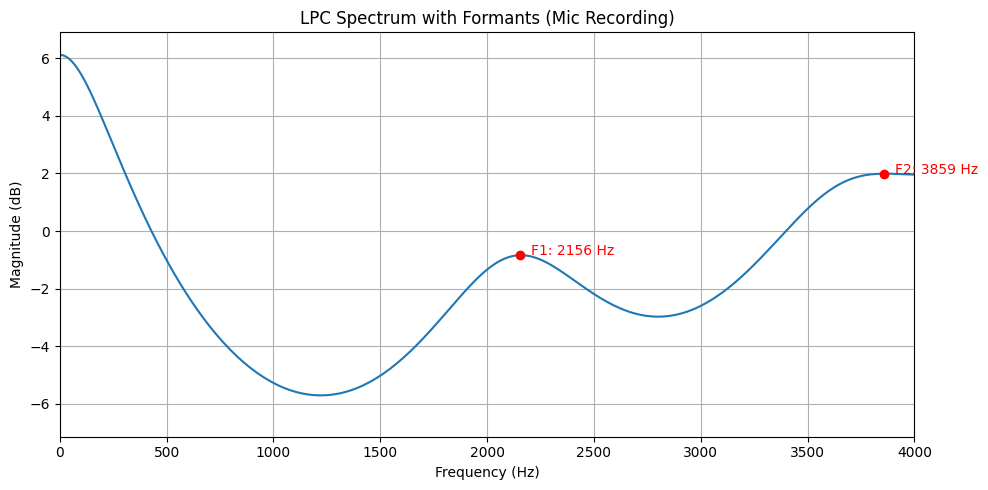

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import lfilter, freqz, correlate, windows, find_peaks

# 녹음된 오디오 파일 로드
#sr은 sample rate를 의미한다.
#y는 recorded.wav의 각 샘플 data들을 저장한다.
y, sr = librosa.load("recorded.wav", sr=16000)

# 중심 30ms 추출
#30ms단위로 frame를 만든다.
center = len(y) // 2
frame_size = int(0.03 * sr)
y_frame = y[center - frame_size//2 : center + frame_size//2]

# Pre-emphasis + 윈도우 적용
#고주파 부분(자음 부분)이 모음 부분에 비해 많이 뭉개지는데, 이를 강조하기 위해 pre-emphasis를 사용한다.
#윈도우 함수로는 hamming function를 사용한다.
y_preemph = lfilter([1, -0.97], 1, y_frame * windows.hamming(len(y_frame)))

# LPC 함수(성도를 모델링 하기 위한 함수)
def lpc_autocorr(signal, order):
    autocorr = correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    R = autocorr[:order + 1]
    A = np.zeros(order)
    E = R[0]
    for i in range(order):
        if E == 0:
            break
        k = (R[i+1] - np.dot(A[:i], R[1:i+1][::-1])) / E
        A[i] = k
        for j in range(i):
            A[j] = A[j] - k * A[i-j-1]
        E *= 1 - k**2
    return np.concatenate(([1], -A))

# LPC 분석
order = 12  #12차 LPC
a = lpc_autocorr(y_preemph, order)
w, h = freqz(1, a, worN=512, fs=sr)
magnitude = 20 * np.log10(np.abs(h))

# 포만트 피크 추출
peaks, _ = find_peaks(magnitude, distance=20)
formant_freqs = w[peaks]
formant_mags = magnitude[peaks]

# 유효 주파수 범위 제한
valid = formant_freqs < 4000  #4kHz까지만 보겠다(실제 주파수의 MAX값의 2배를 본다.).
formant_freqs = formant_freqs[valid]
formant_mags = formant_mags[valid]

# 상위 3개 선택
top_indices = np.argsort(formant_mags)[-3:]
top_formants = sorted(zip(formant_freqs[top_indices], formant_mags[top_indices]))

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(w, magnitude)
plt.title("LPC Spectrum with Formants (Mic Recording)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.xlim(0, 4000)

# Formant 주파수 표시
for i, (f, m) in enumerate(top_formants):
    plt.plot(f, m, 'ro')
    plt.text(f + 50, m, f'F{i+1}: {int(f)} Hz', color='red', fontsize=10)

plt.tight_layout()
plt.show()

- **Pitch (기본 주파수:F0)**: 성대 진동의 주기와 관련된 주파수. 화자의 성별과 감정에 따라 달라지며, prosody 인식에 중요하다. -> 조음을 만들어내는 기본적인 주파수
- **Pitch detection**

/tmp/ipython-input-21-2181242871.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load("recorded.wav", sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


▶ 평균 피치 주파수 (F0): 277.36 Hz


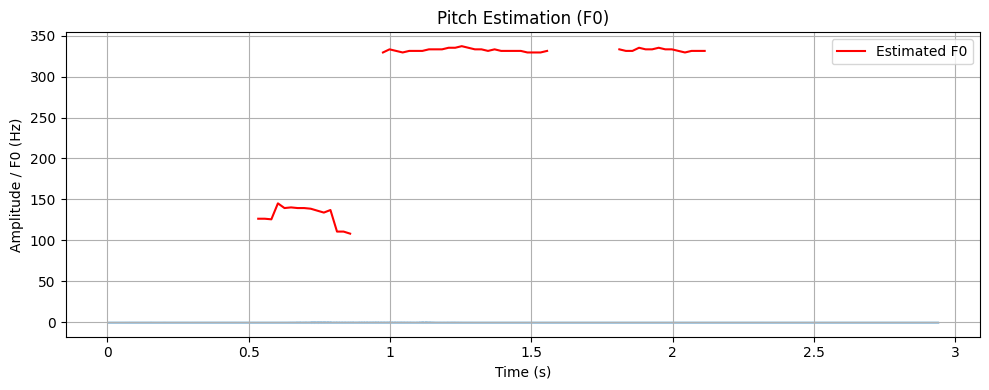

In [ ]:
#pitch 주파수는 성대의 진동으로 인해 발생하는
#기본 주파수여서 음성 합성의 출발이된다.
#피치 추출이 음성인식에서 특징 추출의 기본이다. 사람마다 발성기관의 형태가 다르기에 다 틀리게 나온다.
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 음성 불러오기
y, sr = librosa.load("recorded.wav", sr=16000)

# 피치 추정 (librosa.yin 또는 librosa.pyin 사용 가능)
f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))

# 시간축
times = librosa.times_like(f0)

# 평균 피치 계산 (유성 구간만)
mean_f0 = np.nanmean(f0)
print(f"▶ 평균 피치 주파수 (F0): {mean_f0:.2f} Hz")

# 시각화
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.4)
plt.plot(times, f0, color='r', label='Estimated F0')
plt.title("Pitch Estimation (F0)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude / F0 (Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Pitch shift -> pitch 주파수 이동

반주에서 음정을 올리거나 내릴 때 주로 사용되는 기술이다.

In [9]:
#F0가 피지 주파수이다. 이는 단일 주파수이다.
#100Hz라 가정하면 이를 120Hz로 shift한다면 같은 시간안에 120Hz만큼 주기를 더 많게 해준 것이다.
#80Hz로 shift한다면 단위 시간 내 주기를 낮게 해준다.
#이 피지쉬프트는 왜곡이 많이 일어나기에 주의를 해야한다.
#왜냐, 소리의 주기성을 찾기 어려운 경우가 만기 때문이다.
#주기성을 찾기 못하고 강제로 늘리거나 줄이면 원본의 위상이 틀어져 버리기에 왜곡이 발생한다.
#왜곡없이 이를 부드럽게 맞추는 것을 음성합성이다.
import librosa
import soundfile as sf
import numpy as np
from IPython.display import Audio

# 음성 로딩
y, sr = librosa.load("recorded.wav", sr=16000)

# 피치(F0) 추정
f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))

mean_f0 = np.nanmean(f0)  #기본 주파수
print(f"▶ 현재 평균 피치 주파수: {mean_f0:.2f} Hz")

# 사용자 입력 피치
target_f0 = float(input("원하는 피치 주파수를 입력하세요 (Hz): "))

# 반음 단위 계산
semitone_shift = 12 * np.log2(target_f0 / mean_f0)
print(f"▶ 변조할 반음 수: {semitone_shift:.2f} semitones")

# 피치 변조 수행
y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=semitone_shift)

# 저장
sf.write("shifted.wav", y_shifted, sr)

# 재생
print("▶ 변조된 음성 재생:")
display(Audio("shifted.wav"))

/tmp/ipython-input-9-2519112120.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load("recorded.wav", sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


▶ 현재 평균 피치 주파수: 170.75 Hz
원하는 피치 주파수를 입력하세요 (Hz): 170
▶ 변조할 반음 수: -0.08 semitones
▶ 변조된 음성 재생:


/tmp/ipython-input-8-3673243598.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load('recorded.wav', sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes

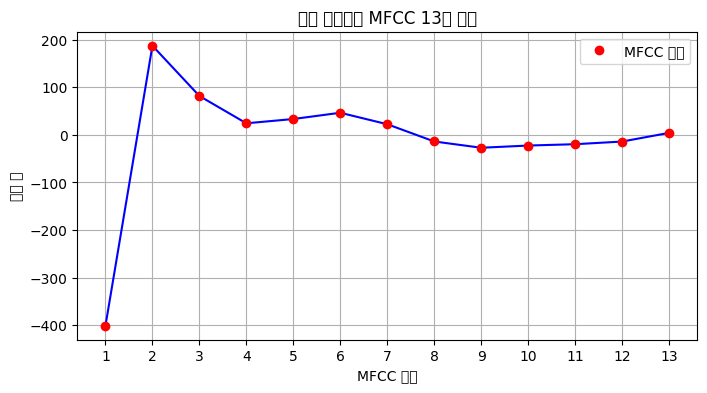

In [8]:
#wave form(전체 음성신호)에서 frame하나 정해서 푸리에 변환후 MFCC로 변환한다.
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 1. 오디오 불러오기
y, sr = librosa.load('recorded.wav', sr=None)

# 2. 무음 제거
intervals = librosa.effects.split(y, top_db=30)
y_voice = np.concatenate([y[start:end] for start, end in intervals])

# 3. MFCC 추출
mfcc = librosa.feature.mfcc(y=y_voice, sr=sr, n_mfcc=13)

# 4. 중간 프레임 선택
frame_index = mfcc.shape[1] // 2
mfcc_frame = mfcc[:, frame_index]

# 5. 시각화: 선은 파란색, 마커는 빨간색 동그라미
x = np.arange(1, 14)

plt.figure(figsize=(8, 4))
plt.plot(x, mfcc_frame, color='blue', linestyle='-')           # 파란 선
plt.plot(x, mfcc_frame, 'ro', label='MFCC 계수')               # 빨간 동그라미 마커
plt.title('중간 프레임의 MFCC 13차 계수')
plt.xlabel('MFCC 차수')
plt.ylabel('계수 값')
plt.xticks(x)
plt.grid(True)
plt.legend()
plt.show()

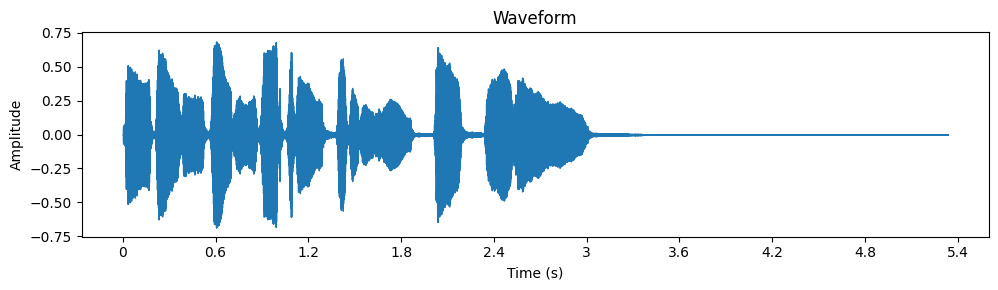

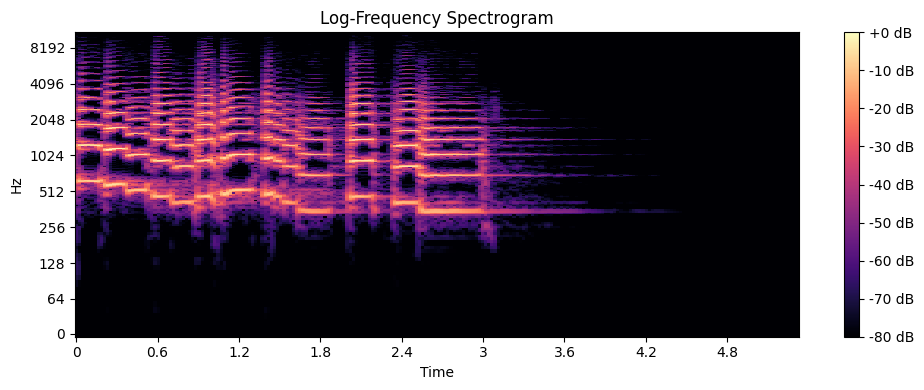

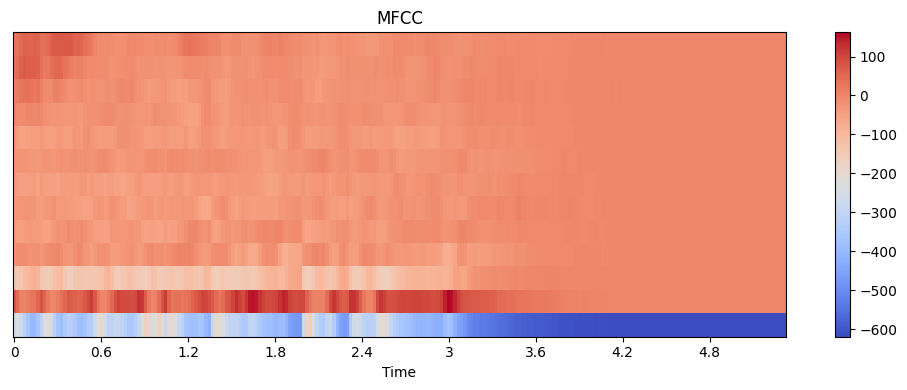

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 1. 음성 파일 불러오기(라이브러리 내장 음원을 가져온다.)
y, sr = librosa.load(librosa.example('trumpet'), sr=None)

# 2. 파형 시각화
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# 3. 스펙트로그램 (STFT)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title("Log-Frequency Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()

# 4. MFCC 추출 및 시각화
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()

/tmp/ipython-input-10-2145694661.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load('recorded.wav', sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-10-2145694661.py:22: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-2145694661.py:22: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-2145694661.py:22: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-10-2145694661.py:22: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/

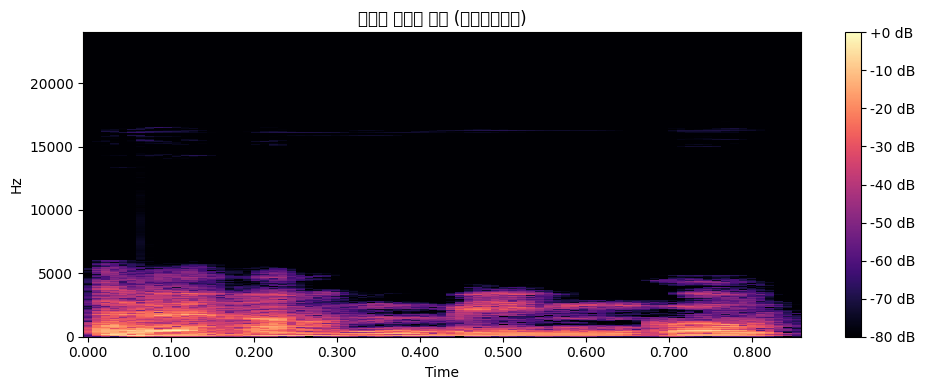

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 1. 음성 파일 로드
y, sr = librosa.load('recorded.wav', sr=None)

# 2. 무음 제거 (옵션)
intervals = librosa.effects.split(y, top_db=30)
y_voice = np.concatenate([y[start:end] for start, end in intervals])

# 3. STFT 적용
D = librosa.stft(y_voice, n_fft=2048, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# 4. 스펙트로그램 시각화
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('음성의 주파수 분석 (스펙트로그램)')
plt.tight_layout()
plt.show()

 100Hz, 1kHz, 10kHz 신호를 생성하고, 시간축(Time Domain)과 퓨리에 변환(FFT)을 이용한 주파수축(Frequency Domain)시각화하는 코드입니다

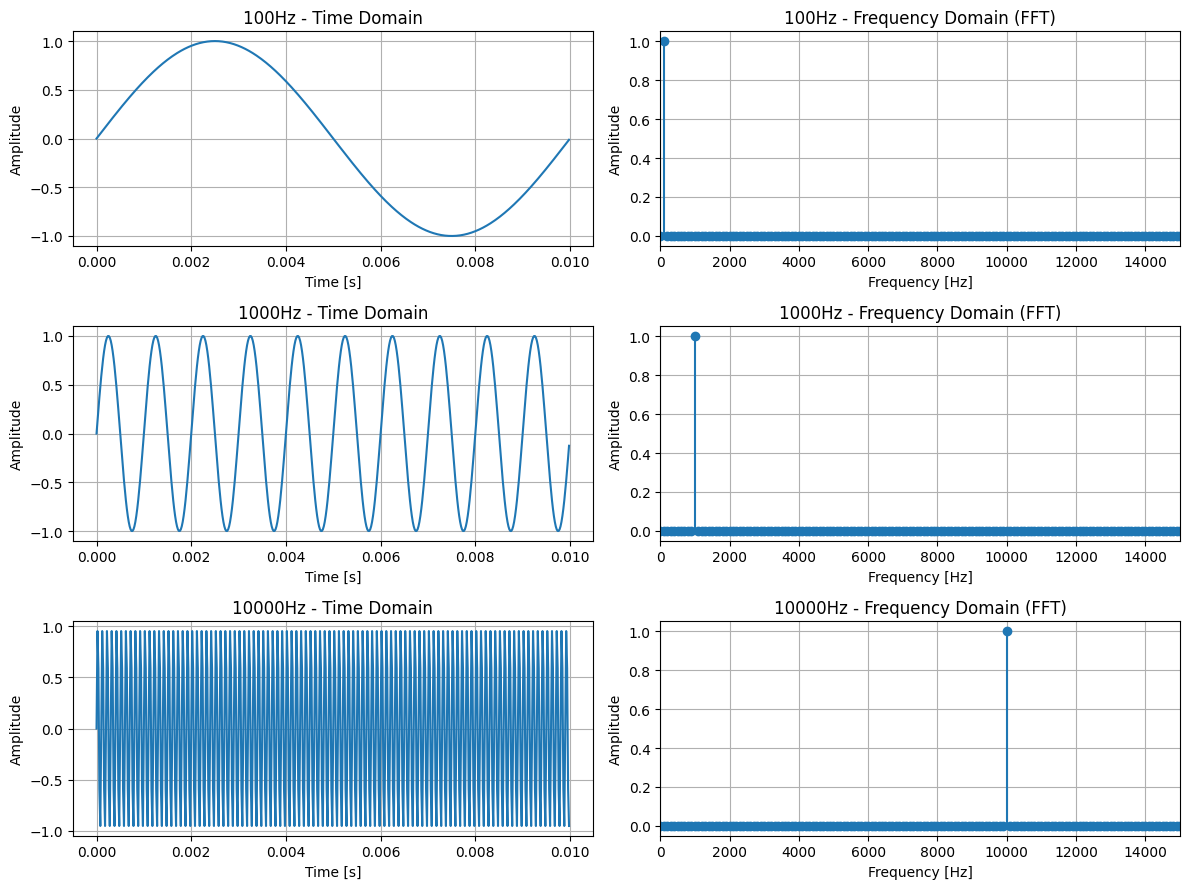

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 샘플링 주파수 설정
fs = 50000  # 50kHz
duration = 0.01  # 10ms
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# 생성할 주파수 리스트
frequencies = [100, 1000, 10000]

# 그래프 초기화
fig, axes = plt.subplots(len(frequencies), 2, figsize=(12, 9))

for idx, freq in enumerate(frequencies):
    # 신호 생성 (사인파)
    signal = np.sin(2 * np.pi * freq * t)

    # 시간 영역 그래프
    axes[idx, 0].plot(t, signal)
    axes[idx, 0].set_title(f'{freq}Hz - Time Domain')
    axes[idx, 0].set_xlabel('Time [s]')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].grid(True)

    # 퓨리에 변환
    fft_signal = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(t), 1/fs)

    # 주파수 영역 그래프
    axes[idx, 1].stem(
        fft_freq[:len(t)//2],
        np.abs(fft_signal[:len(t)//2]) / (len(t)//2),
        basefmt=" "
    )
    axes[idx, 1].set_xlim(0, 15000)
    axes[idx, 1].set_title(f'{freq}Hz - Frequency Domain (FFT)')
    axes[idx, 1].set_xlabel('Frequency [Hz]')
    axes[idx, 1].set_ylabel('Amplitude')
    axes[idx, 1].grid(True)

plt.tight_layout()
plt.show()